# Stock Predictor
LSTM architecture to predict Stockprices based on [this Kaggle Dataset](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)


In [64]:
%matplotlib inline
from IPython.display import display, clear_output
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
import matplotlib
import time
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
torch.manual_seed(1)

<Figure size 432x288 with 0 Axes>

In [86]:
csv = pd.read_csv('./googl.us.txt')
csv.drop(columns=["OpenInt", "Date"], inplace=True)
data = torch.tensor(csv.values, dtype=torch.float)
data = data[:40]
print(data.size()[0])

40


In [91]:
for column in range(5):
    data[:, column] /= torch.max(data[:, column])
    data[:, column] -= data[:, column].mean()

In [80]:
class StockPredictor(nn.Module):
    def __init__(self, layers):
        super(StockPredictor, self).__init__()
        self.layers = layers
        self.lstm = nn.LSTM(5, 1, 1)
        self.lstms = [nn.LSTM(10, 10) for _ in range(layers-1)]
        self.lstms.insert(0, nn.LSTM(5, 10, 1))
        self.final = nn.Linear(10, 1)
        self.activation = nn.LeakyReLU()
    def forward(self, stock, keep_hidden_state=False):
        if not keep_hidden_state:
            self.hidden = [(torch.randn(1, 1, 10),
                       torch.randn(1, 1, 10))for _ in range(self.layers)] + [(torch.randn(1, 1, 1),
                       torch.randn(1, 1, 1))]
        out = torch.zeros(stock.size()[0], 1, 10)
        for i, lstm in enumerate(self.lstms):
            if i != 0:
                out, self.hidden[i] = lstm(out, self.hidden[i])
            else:
                out, self.hidden[i] = lstm(stock, self.hidden[i])
            #out = self.activation(out)
        out = self.final(out)
        return out

In [97]:
model = StockPredictor(3)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.MSELoss()

In [72]:
#load ignore if you want a new model
model.load_state_dict(torch.load("./model.sav"))
model.eval()

StockPredictor(
  (lstm): LSTM(5, 1)
  (final): LSTM(10, 1)
  (activation): LeakyReLU(negative_slope=0.01)
)

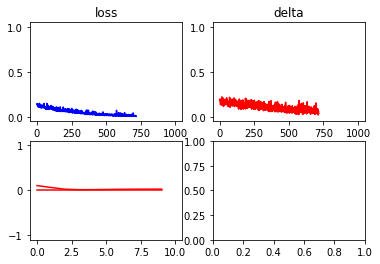

716: 0.035698212683200836 | 0.0034516819287091494
tensor([[ 0.0000e+00,  5.4765e-08,  5.8804e-08,  1.0953e-07, -8.1300e-08],
        [ 0.0000e+00,  2.6340e-09,  3.6635e-09,  5.2681e-09,  1.5964e-09],
        [ 0.0000e+00,  2.9599e-09,  2.8877e-09,  5.9197e-09, -5.8147e-09],
        [ 0.0000e+00, -2.3030e-09, -3.4283e-09, -4.6059e-09, -5.2301e-09],
        [ 0.0000e+00, -1.0412e-09, -4.7747e-10, -2.0823e-09,  4.3123e-09],
        [ 0.0000e+00, -2.5786e-08, -2.6558e-08, -5.1572e-08,  4.3833e-08],
        [ 0.0000e+00,  5.1571e-09,  5.3492e-09,  1.0314e-08, -9.1385e-09],
        [ 0.0000e+00,  2.8340e-10,  5.2902e-10,  5.6680e-10,  7.7071e-10],
        [ 0.0000e+00, -2.9839e-08, -3.3244e-08, -5.9679e-08,  2.8305e-08],
        [ 0.0000e+00,  1.1572e-09,  8.6040e-10,  2.3143e-09, -3.3150e-09],
        [ 0.0000e+00,  5.3127e-08,  5.1372e-08,  1.0625e-07, -1.1704e-07],
        [ 0.0000e+00,  4.0281e-09,  3.7827e-09,  8.0561e-09, -6.2724e-09],
        [ 0.0000e+00,  2.1261e-09,  1.8698e-09,  4

In [ ]:
test_seperate = 3000
epochs = 1000
losses = []
deltas = []
fig, ((lax, dax), (cmpax, _)) = plt.subplots(ncols=2, nrows=2)
lplot, = lax.plot([0, epochs], [1, 0], 'b')
lax.set_title("loss")
dplot, = dax.plot([0, epochs], [1, 0], 'r')
dax.set_title("delta")
rplot, = cmpax.plot([0, data.size()[0]-30], [-1, 1], 'r')
pplot, = cmpax.plot([0, data.size()[0]-30], [-1, 1], 'r')
for epoch in range(epochs):
    model.zero_grad()
    inputs = data[:-30, :].view(-1, 1, 5) #inferring length of the sequence
    target = data[30:, 3]
    prediction = model.forward(inputs)
    loss = (((prediction[:, 0].view(-1) - target)**2)\
        * torch.linspace(0, target.size()[0], target.size()[0])).mean()\
        #+ (1/(prediction[-1]-prediction[-100]))*0.5
    loss.backward()
    optim.step()
    delta = (prediction - data[30:, 3]).abs().mean()
    # visualising learning progress
    deltas.append(np.asscalar(delta.detach().numpy()))
    losses.append(np.asscalar(loss.detach().numpy()))
    lplot.set_data(range(epoch+1), losses)
    dplot.set_data(range(epoch+1), deltas)
    rplot.set_data(range(data.size()[0]-30), target.detach().numpy())
    pplot.set_data(range(data.size()[0]-30), prediction.detach().numpy())
    clear_output(wait=True)
    display(fig)
    print(f'\r{epoch}: {delta} | {loss.detach()}')
    # uncomment for seeing the gradients
    for lstm in model.lstms:
        print(lstm.weight_ih_l0.grad)
        print(lstm.weight_hh_l0.grad)
        print(lstm.bias_ih_l0.grad)
        print(lstm.bias_hh_l0.grad)
    lstm = model.final
    print(lstm.weight.grad)

    print(lstm.bias.grad)

    time.sleep(5)
    
    
plt.show()    
    

In [54]:
#saving
torch.save(model.state_dict(), "./model.sav")